# 06. PyTorch Transfer Learning

TL involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation models

In [1]:
import torch
import torchvision

torchvision.__version__, torch.__version__

('0.18.1+cu121', '2.3.1+cu121')

In [2]:
try:
  import torch
  import torchvision
  assert int(torch.__version__.split('.')[0]) >= 2, 'torch should be ...'
  assert int(torchvision.__version__.split('.')[1]) >= 13, 'torchvision should be ...'
except:
  !pip3 install --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu121
  import torch
  import torchvision

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  !git clone https://github.com/mrdbourke/pytorch-deep-learning.git
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning

  from going_modular.going_modular import data_setup, engine

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [4]:
# Setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data
We need our pizza, steak, sushi data to build a transfer learning model on.

In [5]:
import requests
from pathlib import Path
from zipfile import ZipFile
import os

data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'
image_path.mkdir(parents=True, exist_ok=True)

if len(os.listdir(image_path)) <= 0:
  print('Downloading...')
  response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip')
  with open('pizza_steak_sushi.zip', 'wb') as f:
    f.write(response.content)

  with ZipFile('pizza_steak_sushi.zip', 'r') as f:
    f.extractall(image_path)

  os.remove('pizza_steak_sushi.zip')

Downloading...


## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function.

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision` 0.13+, there's **2** ways to do this:
1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through, it is transformed in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models for transfer learning) right within `torchvision`

In [6]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

manual_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

train_dataloader, test_dataloader, classes = data_setup.create_dataloaders(train_dir, test_dir, manual_transform, batch_size=32)

## 2.2 Creating a transform for torchvision.models (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [7]:
import torchvision
torchvision.__version__

'0.18.1+cu121'

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
type(weights), weights

(<enum 'EfficientNet_B0_Weights'>, EfficientNet_B0_Weights.IMAGENET1K_V1)

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
type(auto_transforms), auto_transforms

(torchvision.transforms._presets.ImageClassification,
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [10]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x784be2d73e50>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it need to run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

Where does the model live?

It is on device? (like a self-driving car)

Or does it live on a server?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms of performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained EfficientNetB0

In [11]:
 # OLD method of creating a pretrained model (prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # 'DEFAULT': best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 96.3MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # example of batch, channels, height, width
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

### 3.4 Freezing the base model and changing the output layer to suit our needs.

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [13]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [14]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [15]:
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

## 4. Train model

In [16]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

results = engine.train(model,
                       train_dataloader,
                       test_dataloader,
                       optimizer,
                       loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9784 | train_acc: 0.5583 | test_loss: 0.6719 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.7148 | train_acc: 0.8167 | test_loss: 0.5588 | test_acc: 0.8727
Epoch: 3 | train_loss: 0.6047 | train_acc: 0.7937 | test_loss: 0.4808 | test_acc: 0.8915
Epoch: 4 | train_loss: 0.4569 | train_acc: 0.9000 | test_loss: 0.4338 | test_acc: 0.8756
Epoch: 5 | train_loss: 0.4566 | train_acc: 0.8812 | test_loss: 0.4090 | test_acc: 0.8858


In [18]:
results

{'train_loss': [0.978387463092804,
  0.7147510051727295,
  0.6047057370344798,
  0.45693532228469846,
  0.45663833022117617],
 'train_acc': [0.5583333333333333, 0.8166666666666667, 0.79375, 0.9, 0.88125],
 'test_loss': [0.6719086170196533,
  0.5587949275970459,
  0.4808284044265747,
  0.4337661623954773,
  0.40904989242553713],
 'test_acc': [0.8914772727272726,
  0.8727272727272727,
  0.8914772727272726,
  0.8755681818181819,
  0.8857954545454545]}

## 5. Evaluating the model by plotting loss curves

In [19]:
try:
  from helper_functions import plot_loss_curves
except:
  import requests

  print('Get from request')
  with open('helper_functions.py', 'wb') as f:
    response = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    f.write(response.content)

  from helper_functions import plot_loss_curves

Get from request


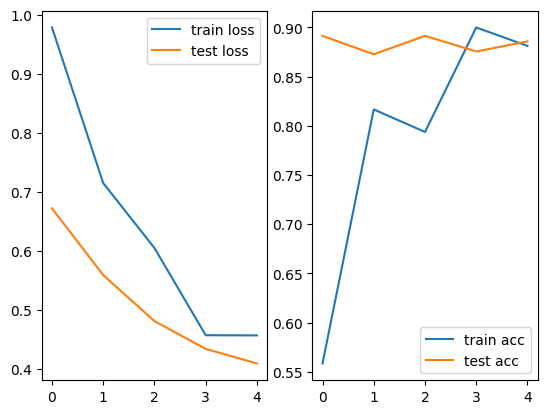

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
x = range(len(results['train_loss']))
ax[0].plot(x, results['train_loss'], label='train loss')
ax[0].plot(x, results['test_loss'], label='test loss')
ax[0].legend()

ax[1].plot(x, results['train_acc'], label='train acc')
ax[1].plot(x, results['test_acc'], label='test acc')
ax[1].legend()

## 6. Make predictions on images from the test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on.
* Same datatype - custom data should be in the same data type.
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you're transformed your custom data, ideally you will transform the test data and custom data the same.

To do all this automagically, let's create a function called `pred_and_plot_image()`:

The function will be similar to the one here:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.open()`
3. Create a transform if one doesn't exist.
4. Make sure the model is on the target device.
5. Turn the model to `model.eval()` model to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size).
7. Make a prediction on the image by passing to the model.
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`.
9. Convert to prediction labels using `torch.argmax()`.
10. Plot the image with `matplotib` and set the title to the prediction label from step 9 and probability from step 8.

In [50]:
import glob
import random
from PIL import Image
from typing import List, Tuple

def pred_and_plot_image(model:nn.Module,
                        filename:str,
                        class_names: List[str],
                        img_size: Tuple[int, int] = (224, 224),
                        transform = None,
                        device: torch.device=device):
  image = Image.open(filename)

  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize(size=img_size),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])])
  ori_image = image
  image = image_transform(image).unsqueeze(0)

  model.eval()
  with torch.inference_mode():
    image = image.to(device)
    logits = model(image)
    probs = torch.softmax(logits, dim=-1)
    pred = torch.argmax(probs, dim=1)[0]

    plt.figure()
    plt.imshow(ori_image)
    plt.title(f'{class_names[pred]} | GT: {filename.parent.name} | Prob: {torch.max(probs, dim=1)[0][0]:.3f}')
    plt.axis(False)

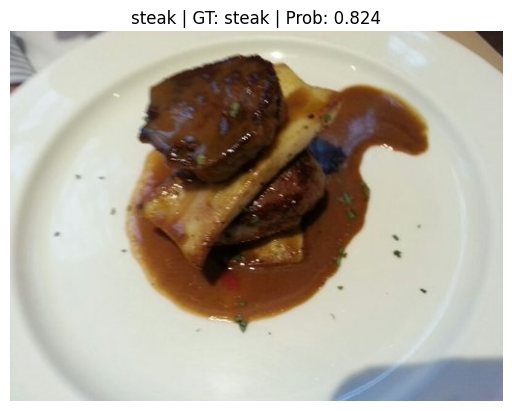

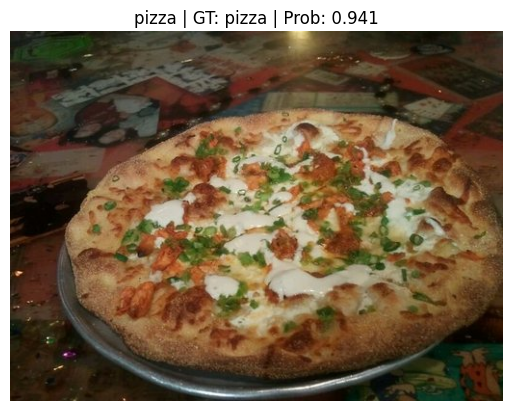

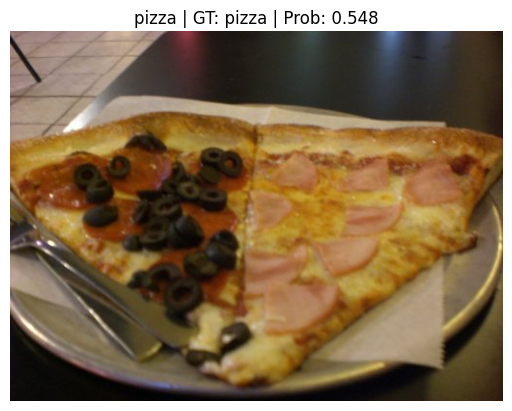

In [51]:
paths = list(test_dir.glob('*/*.jpg'))
filename = random.choice(paths)
filenames = random.sample(population=paths,
                          k=3)
for filename in filenames:
  pred_and_plot_image(model, filename, class_names)

In [52]:
!wget https://www.glueandglitter.com/wp-content/uploads/2022/09/tofu-sushi-hero.jpg

--2024-08-10 10:40:16--  https://www.glueandglitter.com/wp-content/uploads/2022/09/tofu-sushi-hero.jpg
Resolving www.glueandglitter.com (www.glueandglitter.com)... 104.21.76.77, 172.67.191.103, 2606:4700:3037::ac43:bf67, ...
Connecting to www.glueandglitter.com (www.glueandglitter.com)|104.21.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243255 (238K) [image/jpeg]
Saving to: ‘tofu-sushi-hero.jpg’

tofu-sushi-hero.jpg 100%[===================>] 237.55K  --.-KB/s    in 0.04s   

2024-08-10 10:40:16 (5.53 MB/s) - ‘tofu-sushi-hero.jpg’ saved [243255/243255]



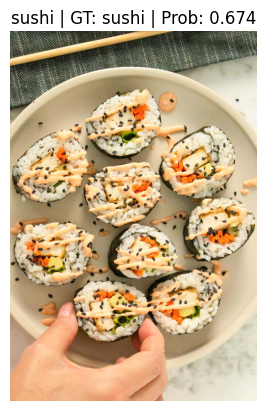

In [55]:
pred_and_plot_image(model, Path('sushi/tofu-sushi-hero.jpg'), class_names)